## Imports

In [1]:
import sys
if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'
import math
import numpy as np, random, operator, pandas as pd
import matplotlib.pyplot as plt
import time
from math import sin, cos, sqrt, atan2, radians

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        R = 6373.0
        lat1 = radians(self.x)
        lon1 = radians(self.y)
        lat2 = radians(city.x)
        lon2 = radians(city.y)
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        #print()
        #print ("route= ",self.route) #******
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create the initial population

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList)) 
        # Returns a list of unique elements chosen from the 
        # population sequence or set. Random sampling without replacement.
    
    return route

In [5]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Genetic Algorithm

### Selection Operator

In [6]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [7]:
def FP_selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        threshold = 100*random.random()
        for i in range(0, len(popRanked)):
            if threshold <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool
    

#### Ordered crossover (OX)  operator

In [9]:
# Ordered crossover (OX) operator

def OX(parent1, parent2):

    child = []
    childA = []
    chP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    
    
    for i in range(startGene, endGene):
        childA.append(parent1[i])
    #print ("sel1 =",childA)
    
    p2=np.roll(parent2,-endGene)
    #print("rotP2 = ", p2)
    #p2=parent2
    
    selP2 = [item for item in p2 if item not in childA]
    #print("selP2 = ", selP2)
   
    chil_raw = childA + selP2
    #print("chil_raw = ", chil_raw)
    
    #child = np.roll(chil_raw, startGene)
    child=chil_raw
    #print ("child = ", child)
    #print ('++++++++++')
    return child, startGene, endGene

#### Cycle crossover (CX) operator

In [10]:

# Cicle crossover (CX) operator

def CX(parent1, parent2):

# initialize child with dummy values
    
    child = []
    p1_indices=[]
    p2_indices=[]
    dummy=(0,0) # this value must not belong to cityList. 
                # In our case that is true, as we generate 
                # the cities on a circunference (see cell 22)
    
    for i in range(0,len(parent1)):
        child.append(dummy)
        de= cityList.index(parent1[i])
        p1_indices.append(de)
        de= cityList.index(parent2[i])
        p2_indices.append(de) 
        
    
    start = int(random.random() * len(parent1))
    start1=start
    child[start]=parent1[start]
    while (parent1[start] != parent2[start1]): 
      index=parent1.index(parent2[start1])
      child[index]=parent1[index]
      start1=index    
    for index,node in enumerate(child):
        if node==(0,0):
            child[index]=parent2[index]
     
    
    return child, start


#### Inversion Reordening (IR)  operator

In [11]:
# Inversion operator

def INV(parent1):
    child = parent1[:]
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    
    for i in range(startGene, endGene+1):
        child[i]=parent1[endGene+startGene-i]

    return child, startGene, endGene

In [12]:
def XoverPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    

    for i in range(0, length):
        r=random.random()
        if r > .7:
           child,_,_ = OX(pool[i], pool[len(matingpool)-i-1])
        elif  r >.3:
           child, _ = CX(pool[i], pool[len(matingpool)-i-1])
        else: 
           child, _, _ = INV(pool[i])
            
        children.append(child)
    return children

### Mutation Operator

In [13]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [14]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

### Put all together: Complete GA

In [15]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = FP_selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = XoverPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

## Running the genetic algorithm

Create list of cities

In [16]:
def plotGraph(br):
    x = list()
    y = list()
    for i in range(len(br)):
        x.append(br[i].x)
        y.append(br[i].y)

    plt.figure(figsize=(6,6))
    plt.scatter(x,y)
    plt.plot(x,y)

## Complete GA

In [17]:
def geneticAlgorithm (population, popSize=1000, eliteSize=20, mutationRate=0.01, generations=500, n_still=5):
    # n_still is the number of route visualizations
    
    t_before = time.time()
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    print("Initial route length: %10.2f"%(1 / rankRoutes(pop)[0][1]))
    print()
    
    ii = int(generations/n_still)
    for i in range(0, generations):
        if (i%ii==0):
            print ()
            plotGraph(pop[-1])
            plt.show()
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        #print()
        sys.stdout.write('\rIterations=  %d  Route length= %10.2f  Time= %10.2f' % ((i+1) , (1 / rankRoutes(pop)[0][1]),(time.time()-t_before)))
        sys.stdout.flush()
        
        #plotGraph(pop)
        
    plotGraph(pop[-1]) 
    plt.show()
    
    print()
    print("Final route length: %10.2f" %(1 / rankRoutes(pop)[0][1]))
    print("  Time = ", round (time.time()-t_before, 2), " seconds")
    
    plt.plot(progress)
    plt.ylabel('Route length')
    plt.xlabel('Generation')
    plt.show()
  
    
    return pop[-1]

## RUN -GA

In [18]:
nCities=23
x=[44.40711,44.41308,44.40856,44.40726,44.3991,44.4064,44.42032,44.41182,44.40252,44.41748,44.39676,44.40275,44.42269,44.41892,44.41365,44.40682,44.40486,44.39637,44.39343,44.40234,44.41027,44.41389,44.40796]
y=[8.96546,8.96966,8.95999,8.97667,8.96421,8.952,8.96635,8.95258,8.95401,8.95572,8.97581,8.98595,8.95693,8.94967,8.94446,8.93501,8.9435,8.94834,8.985893,8.93884,8.93558,8.93239,8.92816]
cityList = []


for i in range(0,nCities):
      cityList.append(City(x[i], y[i]))
  

Initial route length:      36.16




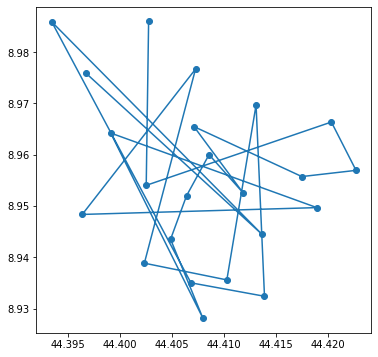

Iterations=  600  Route length=      17.15  Time=     249.50


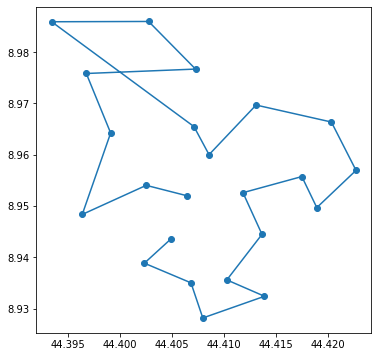

Iterations=  1200  Route length=      17.15  Time=     499.30


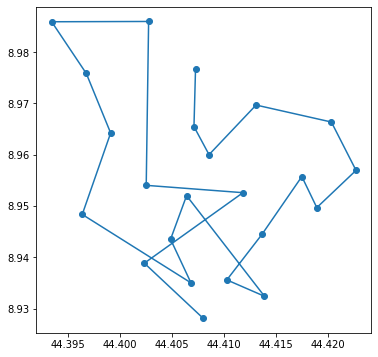

Iterations=  1800  Route length=      17.15  Time=     748.09


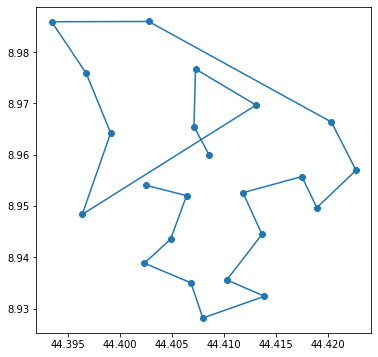

Iterations=  2400  Route length=      17.15  Time=     997.43


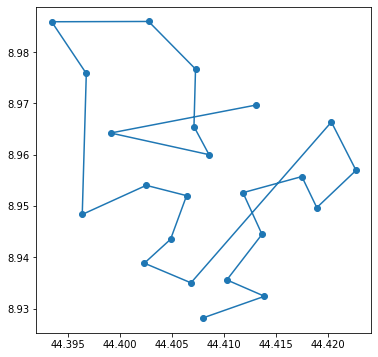

Iterations=  3000  Route length=      17.15  Time=    1247.35

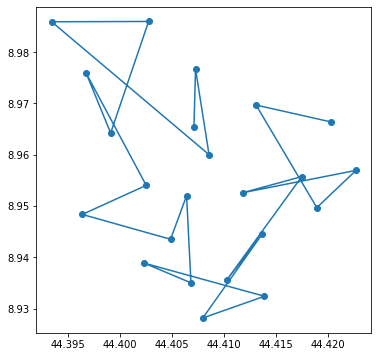


Final route length:      17.15
  Time =  1247.52  seconds


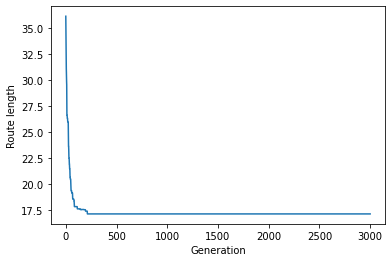

Optimal route is:  [7, 2, 14, 13, 8, 10, 21, 15, 23, 22, 20, 16, 6, 17, 18, 9, 11, 5, 12, 19, 3, 4, 1]


In [25]:
bestr = geneticAlgorithm(population=cityList, popSize=200, eliteSize=10, mutationRate=0.002, generations=3000 )
cityIndices=[]
for cities in bestr:
    cityIndices.append((x.index(cities.x))+1)

print("Optimal route is: ",cityIndices)
